In [ ]:
!pip install giniclust3
!pip install scanpy
!pip install anndata
!pip install leidenalg
!pip install desc
!pip install matplotlib==3.1.3
# !pip install dca

  Created wheel for giniclust3: filename=giniclust3-1.0.1-py3-none-any.whl size=7278 sha256=f291de6775b7d02412d2deb05649d520e9303c5f6c2e0dc983b28a116810f0a3
  Stored in directory: /root/.cache/pip/wheels/38/03/95/73670883bf24d6d3980251f570742fc7f882de7f056d33a765
Successfully built giniclust3
     |████████████████████████████████| 2.0 MB 7.6 MB/s 
     |████████████████████████████████| 88 kB 7.2 MB/s 
     |████████████████████████████████| 11.2 MB 31.9 MB/s 
     |████████████████████████████████| 96 kB 4.8 MB/s 
     |████████████████████████████████| 930 kB 36.3 MB/s 
     |████████████████████████████████| 1.1 MB 21.0 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=dd3530db873489bc29474e821e3bcbdd0f36b6cbaa44c9c904008922fbf6b1f6
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename

     |████████████████████████████████| 1.3 MB 7.2 MB/s 
     |████████████████████████████████| 3.1 MB 42.5 MB/s 
     |████████████████████████████████| 5.1 MB 6.6 MB/s 
     |████████████████████████████████| 1.1 MB 43.4 MB/s 
     |████████████████████████████████| 462 kB 42.3 MB/s 
     |████████████████████████████████| 13.1 MB 6.7 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.1
    Uninstalling matplotlib-3.5.1:
      Successfully uninstalled matplotlib-3.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scanpy 1.9.1 requires matplotlib>=3.4, but you have matplotlib 3.1.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import scanpy as sc
import numpy as np
import giniclust3 as gc
import anndata
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
import desc
import pandas as pd
import sys
from scipy import stats
import h5py
from sklearn.metrics import adjusted_rand_score as ari
from sklearn.metrics import normalized_mutual_info_score as nmi
from sklearn import metrics
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Simulated Dataset

In [ ]:
# Read simulated dataset
# %run /content/drive/MyDrive/Statistical_ML/ML_Final_Project/Dataset/Filtered\ Dataset\ Final.ipynb
# %store -r adata_final

In [ ]:
# # Load bladder dataset (from scAIDE)
# with h5py.File("/content/drive/MyDrive/Statistical_ML/ML_Final_Project/GiniClust/dataset/Shekhar_mouse_retina.h5", "r") as bladder:
#     adataBladder = sc.AnnData(X = np.array(bladder["X"]))
#     adataBladder.obs['true'] = np.array(bladder["Y"])
#     Retina_df = pd.DataFrame(np.array(bladder['X']))

In [ ]:
# Load Dataset (Simulated Dataset using Splatter)
with h5py.File("/content/drive/MyDrive/ML_Final_Project/GiniClust/dataset/Simulate_Splatter/proportion/sim_0.1.h5ad", "r") as sim:
    adatasim = sc.AnnData(X=np.array(sim['X']))
    datasim = adatasim.X
    obs = {'Batch': np.array(sim['obs']['Batch']),
        'ExpLibSize': np.array(sim['obs']['ExpLibSize']),
        'Group': np.array(sim['obs']['Group'])}
    var = {'BaseGeneMean': np.array(sim['var']['BaseGeneMean']),
        'DEFacGroup1': np.array(sim['var']['DEFacGroup1']),
        'DEFacGroup2': np.array(sim['var']['DEFacGroup2']),
        'GeneMean': np.array(sim['var']['GeneMean']),
        'OutlierFactor': np.array(sim['var']['OutlierFactor'])}

    adatasim.obs = pd.DataFrame(obs)
    adatasim.var = pd.DataFrame(var)

In [ ]:
# Make a copy of the raw data
adataSimulate = adatasim.copy()
adataSimulate

AnnData object with n_obs × n_vars = 500 × 2000
    obs: 'Batch', 'ExpLibSize', 'Group'
    var: 'BaseGeneMean', 'DEFacGroup1', 'DEFacGroup2', 'GeneMean', 'OutlierFactor'

In [ ]:
adatasim

AnnData object with n_obs × n_vars = 500 × 2000
    obs: 'Batch', 'ExpLibSize', 'Group'
    var: 'BaseGeneMean', 'DEFacGroup1', 'DEFacGroup2', 'GeneMean', 'OutlierFactor'

In [ ]:
# Preprocessing and store adataSimulate for calculating GiniIndex and FanoFactor
sc.pp.filter_cells(adataSimulate, min_counts=1)
sc.pp.filter_genes(adataSimulate, min_counts=1)
# adataSimulate = anndata.AnnData(X=adataSimulate.X.T,obs=adataSimulate.var,var=adataSimulate.obs)
sc.pp.normalize_per_cell(adataSimulate, counts_per_cell_after=1e4)
print(adataSimulate)

AnnData object with n_obs × n_vars = 500 × 1990
    obs: 'Batch', 'ExpLibSize', 'Group', 'n_counts'
    var: 'BaseGeneMean', 'DEFacGroup1', 'DEFacGroup2', 'GeneMean', 'OutlierFactor', 'n_counts'


In [ ]:
# Calculate Fano factor
gc.fano.calFano(adataSimulate) 
adataFano=gc.fano.clusterFano(adataSimulate) ###Cluster based on Fano factor

# Calculate Gini index
gc.gini.calGini(adataSimulate, min_gini_value=0.2) 
adataGini=gc.gini.clusterGini(adataSimulate, neighbors=5) ###Cluster based on Fano factor

Gene number is 1990
Cell number is 500


In [ ]:
# Functions for making consensus matrix
from sklearn.cluster import KMeans
def determinK(gini,fano):
    cellNum = 0
    for g in gini.keys():
        cellNum = cellNum+len(gini[g])
    count = 0
    rare = 0
    for g in gini.keys():
        if (len(gini[g])/cellNum>0.01):
            continue
        rare = rare + 1
        for f in fano.keys():
            overlap = len(np.intersect1d(gini[g],fano[f]))
            overlapG = overlap/len(gini[g])
            overlapF = overlap/len(fano[f])
            if (overlapG>=0.8 and overlapF>=0.8):
                count += 1
    k = rare + len(fano) - count
    return (k)

def clusterMtilde(GCconsensus,**kwargs):
    """
    Cluster consensus Mtilde matrix based on Gini and Fano cluster results.
    Params
    ------
    GCDict
        GCDict returned from generateMtilde
    k: int, optional 
        Number of K in KMeans clustering. Default value based on Gini and Fano
        cluster results.
    Returns
    -------
    Returns dictionary with KMeans cluster result. GCDict['finalCluster']
    """
    k_auto = determinK(GCconsensus['giniCellDict'],GCconsensus['fanoCellDict'])
    K = kwargs.get('k',k_auto)
    kmeans = KMeans(n_clusters=K,n_init=100).fit(GCconsensus['Mtilde'])
    finalClustIndex = kmeans.labels_
    GCconsensus['finalIndex'] = np.array(finalClustIndex)

    ###project to each single cell###
    hashProject = {}
    for i in range(len(GCconsensus['finalIndex'])):
        key = str(GCconsensus['giniIndex'][i])+"_"+str(GCconsensus['fanoIndex'][i])
        hashProject[key] = GCconsensus['finalIndex'][i]
    finalClust = []
    for i in range(len(GCconsensus['overlap'])):
        key = str(GCconsensus['overlap'][i])+"_"+str(GCconsensus['fanoCluster'][i])
        finalClust.append(str(hashProject[key]))

    ###sort and remark clusters###
    remarkClust = []
    hashFinalCount = {}
    for i in range(len(finalClust)):
        hashFinalCount[finalClust[i]] = hashFinalCount.get(finalClust[i],0) + 1
    diCount = []
    for i in hashFinalCount.keys():
        listCount = []
        listCount.append(i)
        listCount.append(hashFinalCount[i])
        diCount.append(listCount)
    diCount.sort(key=lambda x:x[1], reverse=True)
    hashFinalProject = {}
    for i in range(len(diCount)):
        hashFinalProject[diCount[i][0]] = str(i)
    finalSortedClust = []
    for i in range(len(finalClust)):
        finalSortedClust.append(hashFinalProject[finalClust[i]])
    GCconsensus['finalCluster'] = finalSortedClust

In [ ]:
sum(adataSimulate.obs['rare'].to_numpy().astype(int))

8

In [ ]:
consensusCluster={}
consensusCluster['giniCluster']=np.array(adataSimulate.obs['rare'].values.tolist())
consensusCluster['fanoCluster']=np.array(adataSimulate.obs['fano'].values.tolist())
gc.consensus.generateMtilde(consensusCluster) ###Generate consensus matrix
clusterMtilde(consensusCluster) ###Cluster consensus matrix
# np.savetxt("final.txt",consensusCluster['finalCluster'], delimiter="\t",fmt='%s')

In [ ]:
adataGini.obs['final']=consensusCluster['finalCluster']
adataFano.obs['final']=consensusCluster['finalCluster']
adataSimulate.obs['final'] = consensusCluster['finalCluster']

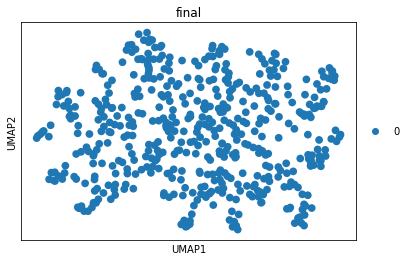

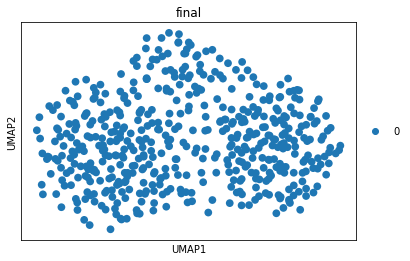

In [ ]:
### Gini - UMAP
# sc.pp.neighbors(adataGini)
sc.tl.umap(adataGini)
sc.pl.umap(adataGini, color='final')

### Fano - UMAP
# sc.pp.neighbors(adataFano)
sc.tl.umap(adataFano)
sc.pl.umap(adataFano, color='final')

         Falling back to preprocessing with `sc.pp.pca` and default params.


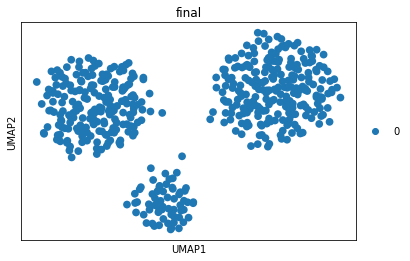

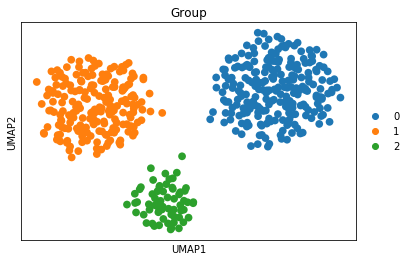

In [ ]:
sc.pp.neighbors(adataSimulate)
sc.tl.umap(adataSimulate)
sc.pl.umap(adataSimulate, color='final')
# convert 'cluster_id' to category type
adataSimulate.obs['Group'] = adataSimulate.obs['Group'].to_numpy().astype(str)
sc.pl.umap(adataSimulate, color='Group')

In [ ]:
# Use ari and nmi as the criteria to evaluate the accuracy
labels_pred = adataSimulate.obs['final'].to_numpy().astype(int)
labels_true = adataSimulate.obs['Group'].to_numpy().astype(int)

labels_pred_rare = labels_pred[labels_true == 2]
labels_true_rare = labels_true[labels_true == 2]

# make the labels consistent (1 -> 0, 0 -> 1)
# labels_pred[labels_pred == 0] = 3
# labels_pred[labels_pred == 1] = 0
# labels_pred[labels_pred == 3] = 1

ariScore_desc = ari(labels_true, labels_pred)
nmiScore_desc = nmi(labels_true, labels_pred)

fpr, tpr, thresholds = metrics.roc_curve(labels_true, labels_pred, pos_label=2)
auc_desc = metrics.auc(fpr, tpr)
f1_score_desc = metrics.f1_score(labels_true_rare, labels_pred_rare, average='micro')

In [ ]:
print(ariScore_desc)
print(nmiScore_desc)
print(auc_desc)
print(f1_score_desc)

0.0
0.0
0.5
0.0


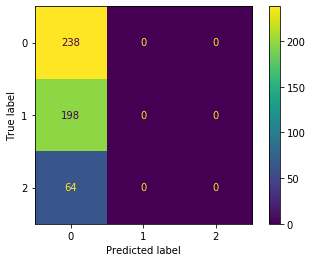

In [ ]:
# confusion matrix
confusion_matrix = metrics.confusion_matrix(labels_true, labels_pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix)
disp.plot()
plt.show()

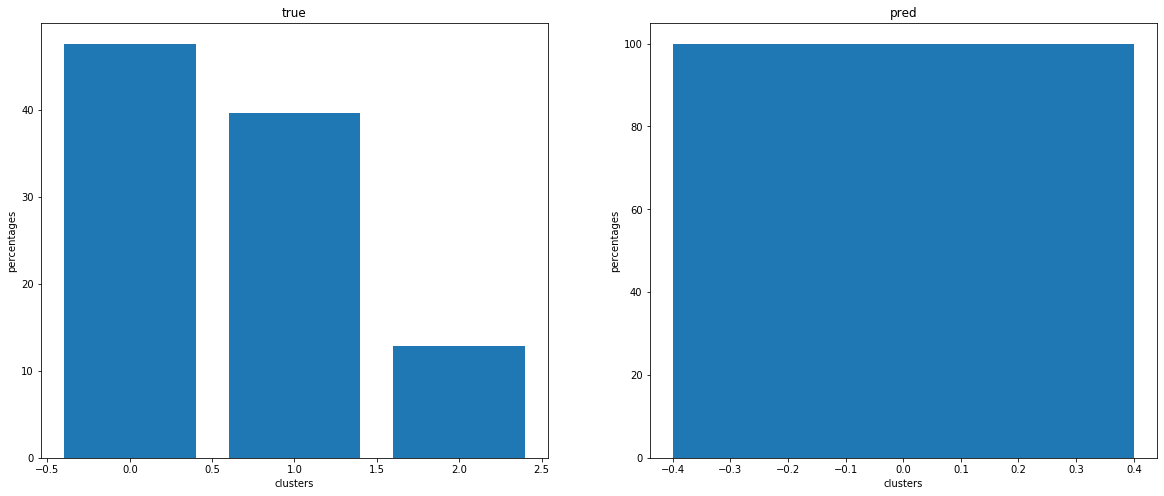

In [ ]:
clusters_true = adataSimulate.obs['Group'].to_numpy().astype(float).tolist()
clusters_num_true = np.unique(clusters_true)
percentages_true = []

clusters_pred = adataSimulate.obs['final'].to_numpy().astype(float).tolist()
clusters_num_pred = np.unique(clusters_pred)
percentages_pred = []

for n in clusters_num_true:
    count = clusters_true.count(n)
    percent = count / adataSimulate.shape[0] * 100
    percentages_true.append(percent)

for n in clusters_num_pred:
    count = clusters_pred.count(n)
    percent = count / adataSimulate.shape[0] * 100
    percentages_pred.append(percent)

fig = plt.figure(figsize=(20, 8))
axes = fig.add_subplot(1, 2, 1)
axes.bar(clusters_num_true, percentages_true)
axes.set_xlabel("clusters")
axes.set_ylabel("percentages")
axes.set_title("true")

axes = fig.add_subplot(1, 2, 2)
axes.bar(clusters_num_pred, percentages_pred)
axes.set_xlabel("clusters")
axes.set_ylabel("percentages")
axes.set_title("pred")

plt.show()